# Import Necessary Libraries

In [1]:
!pip install -q albumentations==0.5.2
import albumentations as A
A.__version__

'0.5.2'

In [2]:
import torch
torch.__version__

'1.11.0'

In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
import torchvision
torchvision.__version__

'0.12.0'

In [5]:
!pip install -q pytorch_lightning
import pytorch_lightning as pl
print(pl.__version__)

1.9.0


# Create Dataset with Data Augmentation for Training

In [6]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from xml.etree.ElementTree import parse
from albumentations.pytorch import ToTensor

In [7]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([
            A.HorizontalFlip(p = 0.1),
            A.VerticalFlip(p = 0.1),
            A.RandomBrightnessContrast(p = 0.1),
            ToTensor()
          ], bbox_params = bbox_params)

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox')
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

In [8]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset1 = MaskDataset(root)

In [9]:
len(dataset1)

853

In [10]:
x, t = dataset1[0]

In [11]:
x

tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0.

In [12]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([3, 366, 512]))

In [13]:
t

{'boxes': tensor([[ 79., 105., 109., 142.],
         [185., 100., 226., 144.],
         [325.,  90., 360., 141.]]),
 'labels': tensor([1, 2, 1]),
 'image_id': tensor([0]),
 'area': tensor([1110., 1804., 1785.]),
 'iscrowd': tensor([0, 0, 0])}

## Some data have become impoper because of data augmentation. They must be removed from the training dataset.

In [14]:
x.shape[2]

512

In [15]:
t['boxes'][0][2].item()

109.0

In [16]:
len(t['boxes'])

3

In [17]:
for i in range(len(t['boxes'])):
    if x.shape[2] < t['boxes'][i][2]:
        print(x.shape)
        print(t)
    else:
        print('No problem.')

No problem.
No problem.
No problem.


In [18]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"Error at {i}.")

Error at 5.
Error at 93.
Error at 110.
Error at 231.
Error at 251.
Error at 457.
Error at 501.
Error at 603.
Error at 616.
Error at 706.
Error at 787.


In [19]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"{i},")

5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787,


In [20]:
removed_list = [5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787]

In [21]:
dataset = []
for i in range(len(dataset1)):
    if i in removed_list:
        pass
    else:
        dataset.append(dataset1[i])

In [22]:
len(dataset)

842

In [23]:
for i in range(len(dataset)):
    try:
        x, t = dataset[i]
    except Exception as e:
        print(f"Error at {i}.")

In [24]:
dataset1 = dataset

In [25]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"Error at {i}.")

# Visualize Sample Data

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [27]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [28]:
def visualize_boxes(x, t):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = x.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = t['boxes'].cpu().detach().numpy()
    labels = t['labels'].cpu().detach().numpy()

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

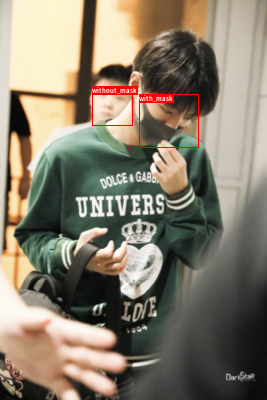

In [29]:
visualize_boxes(x, t)

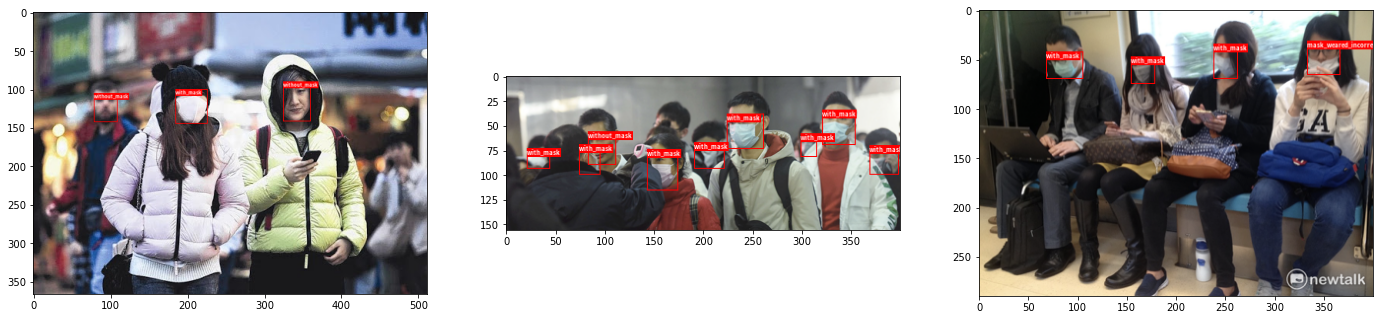

In [30]:
plt.figure(figsize = (24, 12))
for i in range(3):
    x, t = dataset1[i]
    image = visualize_boxes(x, t)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

In [31]:
train1, val1, test1 = torch.utils.data.random_split(dataset = dataset1, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(4))

In [32]:
len(train1), len(val1), len(test1)

(752, 40, 50)

In [33]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

train_loader = torch.utils.data.DataLoader(train1, batch_size, shuffle = False, drop_last = True, collate_fn = collate_fn)

In [34]:
x, t = next(iter(train_loader))

In [35]:
x

(tensor([[[0.3922, 0.3843, 0.3961,  ..., 0.5922, 0.5922, 0.5843],
          [0.4039, 0.3922, 0.4078,  ..., 0.5922, 0.5882, 0.5843],
          [0.4078, 0.4000, 0.4000,  ..., 0.5882, 0.5882, 0.5765],
          ...,
          [0.0549, 0.0275, 0.0275,  ..., 0.3686, 0.3608, 0.3569],
          [0.0549, 0.0235, 0.0235,  ..., 0.3725, 0.3686, 0.3490],
          [0.0863, 0.0549, 0.0588,  ..., 0.3922, 0.3725, 0.3647]],
 
         [[0.3647, 0.3608, 0.3686,  ..., 0.5961, 0.5961, 0.5882],
          [0.3765, 0.3686, 0.3804,  ..., 0.5961, 0.5922, 0.5882],
          [0.3843, 0.3725, 0.3765,  ..., 0.5922, 0.5922, 0.5804],
          ...,
          [0.0627, 0.0353, 0.0353,  ..., 0.3804, 0.3725, 0.3686],
          [0.0627, 0.0314, 0.0314,  ..., 0.3843, 0.3804, 0.3608],
          [0.0902, 0.0588, 0.0627,  ..., 0.4000, 0.3843, 0.3804]],
 
         [[0.3176, 0.3176, 0.3255,  ..., 0.6196, 0.6196, 0.6078],
          [0.3333, 0.3216, 0.3333,  ..., 0.6157, 0.6157, 0.6118],
          [0.3412, 0.3255, 0.3294,  ...,

In [36]:
len(x)

8

In [37]:
t

({'boxes': tensor([[156.,  54., 254., 163.],
          [ 35., 170.,  90., 223.],
          [234.,  17., 294.,  96.]]),
  'labels': tensor([2, 2, 1]),
  'image_id': tensor([349]),
  'area': tensor([10682.,  2915.,  4740.]),
  'iscrowd': tensor([0, 0, 0])},
 {'boxes': tensor([[148., 130., 176., 161.],
          [233., 126., 261., 155.],
          [ 43., 138.,  62., 160.],
          [108., 115., 131., 137.],
          [288., 116., 303., 138.],
          [318., 133., 336., 151.],
          [365., 129., 382., 148.],
          [188., 132., 199., 147.]]),
  'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([570]),
  'area': tensor([868., 812., 418., 506., 330., 324., 323., 165.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[295.,  75., 334., 115.],
          [198.,  91., 223., 116.],
          [225.,  65., 248.,  90.],
          [119.,  85., 149., 115.]]),
  'labels': tensor([2, 2, 2, 2]),
  'image_id': tensor([278]),
  'area': tensor([1560.,  625.,  575

In [38]:
type(x)

tuple

# Create Dataset without Data Augmentation for Validation and Test

In [39]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([ToTensor()], bbox_params = bbox_params)
    

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox') # Add
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

In [40]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset2 = MaskDataset(root)

In [41]:
dataset = []
removed = []
for i in range(len(dataset2)):
    if i in removed_list:
        removed.append(dataset2[i])
    else:
        dataset.append(dataset2[i])

In [42]:
len(dataset)

842

In [43]:
dataset2 = dataset

In [44]:
train2, val2, test2 = torch.utils.data.random_split(dataset = dataset2, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(42))

In [45]:
len(train2), len(val2), len(test2)

(752, 40, 50)

## The removed data can be used for validation or test.

In [46]:
val = []
for i in range(len(val2)):
    val.append(val2[i])
for i in range(len(removed)):
    val.append(removed[i])
len(val)

51

In [47]:
val2 = val
len(val2)

51

In [48]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

val_loader = torch.utils.data.DataLoader(val2, batch_size, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test2, batch_size, collate_fn = collate_fn)

# Training, Validation, and Test with Faster R-CNN

In [49]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [50]:
class Net(pl.LightningModule):

    def __init__(self, n_feature = 1024, n_class = 4):
        super().__init__()

        self.model = fasterrcnn_resnet50_fpn(pretrained = True)
        self.model.roi_heads.box_predictor = FastRCNNPredictor(n_feature, n_class)

    def forward(self, x, t = None):
        if self.training:
            return self.model(x, t)
        else:
            return self.model(x)


    def training_step(self, batch, batch_idx):
        x, t = batch
        losses = self(x, t)
        loss = sum(losses.values())
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('val_loss', loss, on_step = False, on_epoch = True)


    def test_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('test_loss', loss, on_step = False, on_epoch = True)


    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params)
        return optimizer

In [51]:
pl.seed_everything(0)
net = Net()
trainer = pl.Trainer(max_epochs = 20, gpus = 1, deterministic = True)
trainer.fit(net, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:468: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [52]:
trainer.test(dataloaders = test_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:128: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3494381904602051     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3494381904602051}]

In [53]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

# Visualize the Results

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [55]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [56]:
def visualize_results(input, output):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = input.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = output['boxes'].cpu().detach().numpy()
    labels = output['labels'].cpu().detach().numpy()

    if 'scores' in output.keys():
        scores = output['scores'].cpu().detach().numpy()
        boxes = boxes[scores > 0.5]
        labels = labels[scores > 0.5]

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

In [57]:
net.cpu().eval()
x, t = test2[0]
y = net(x.unsqueeze(0))[0]

In [58]:
x

tensor([[[0.2314, 0.1529, 0.0784,  ..., 0.3804, 0.3804, 0.3647],
         [0.2000, 0.1137, 0.0980,  ..., 0.3686, 0.3765, 0.3725],
         [0.1725, 0.0902, 0.1020,  ..., 0.3725, 0.3843, 0.3804],
         ...,
         [0.1333, 0.1490, 0.1490,  ..., 0.5373, 0.5373, 0.5294],
         [0.1255, 0.1490, 0.1529,  ..., 0.5333, 0.5333, 0.5294],
         [0.1176, 0.1333, 0.1412,  ..., 0.5333, 0.5333, 0.5294]],

        [[0.3216, 0.2196, 0.1608,  ..., 0.4510, 0.4510, 0.4431],
         [0.3020, 0.2118, 0.1490,  ..., 0.4392, 0.4549, 0.4549],
         [0.2863, 0.1804, 0.1451,  ..., 0.4510, 0.4667, 0.4627],
         ...,
         [0.2314, 0.2549, 0.2588,  ..., 0.5922, 0.5922, 0.5843],
         [0.2275, 0.2471, 0.2588,  ..., 0.5961, 0.5961, 0.5922],
         [0.2078, 0.2314, 0.2431,  ..., 0.5961, 0.5961, 0.5922]],

        [[0.2941, 0.2118, 0.1490,  ..., 0.4078, 0.4196, 0.4118],
         [0.2784, 0.1882, 0.1490,  ..., 0.3961, 0.4196, 0.4235],
         [0.2627, 0.1647, 0.1451,  ..., 0.4078, 0.4275, 0.

In [59]:
t

{'boxes': tensor([[124.,  48., 143.,  96.],
         [201.,  89., 235., 121.],
         [226.,  15., 271.,  66.]]),
 'labels': tensor([1, 1, 2]),
 'image_id': tensor([189]),
 'area': tensor([ 912., 1088., 2295.]),
 'iscrowd': tensor([0, 0, 0])}

In [60]:
y

{'boxes': tensor([[223.9818,  15.0269, 273.5369,  70.0786],
         [201.2807,  87.9650, 231.9425, 120.2677],
         [362.2025,  95.8470, 376.6754, 112.1808],
         [254.6343,  66.9802, 331.6173, 125.0443],
         [223.8642,   8.0761, 281.5700, 104.0400],
         [ 74.3794,  85.6017, 130.4545, 159.4207],
         [224.3052,   9.6843, 284.9413,  78.6509],
         [ 57.7533,  64.5216, 154.8759, 199.1029],
         [265.3414,  21.8186, 284.7244,  45.4680],
         [208.7254, 118.1686, 307.3155, 200.0000],
         [199.4230,  89.6251, 230.9173, 122.1050],
         [238.3148,  58.3212, 257.2149,  72.6917],
         [210.2691,  17.9838, 326.1819, 131.0968],
         [268.0218,  21.3997, 284.0100,  46.3660],
         [244.6163,  50.3600, 331.1759, 128.3764],
         [164.0665,  98.3006, 200.4631, 132.7406],
         [269.9484,  26.9525, 280.7034,  42.8764],
         [211.0333,  19.3204, 324.9286, 129.6752],
         [ 71.9285,  69.5339, 141.4344, 156.3267],
         [199.0799,  8

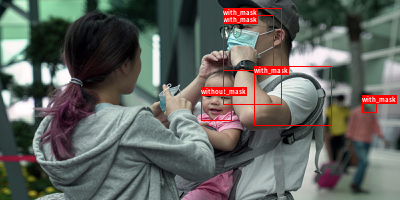

In [61]:
visualize_results(x, y)

In [62]:
x, t = test2[1]
y = net(x.unsqueeze(0))[0]

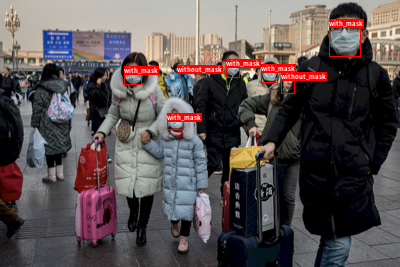

In [63]:
visualize_results(x, y)

# Non-Maximum Suppression (NMS) to Select the Best Boxes

In [64]:
from torchvision.ops import batched_nms

In [65]:
keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
keep

tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 16, 18])

In [66]:
y['boxes'][keep]

tensor([[329.4395,  19.4242, 360.0910,  56.4771],
        [124.2233,  66.7879, 141.6432,  84.7601],
        [261.7509,  64.9462, 277.3449,  82.6242],
        [226.0716,  59.8490, 239.0320,  77.2921],
        [167.9427, 113.8305, 183.2612, 129.3658],
        [281.8168,  72.9094, 294.3567,  93.1304],
        [177.6885,  65.2053, 186.0782,  72.5368],
        [245.9014,  79.5809, 266.4256, 100.2302],
        [281.7417,  73.3806, 296.1592,  94.0952],
        [178.3068, 237.7452, 188.4354, 251.8574],
        [194.3213,  71.1271, 199.9680,  82.8919],
        [283.4515,  72.3275, 296.3458,  96.7987],
        [245.2185,  79.4611, 266.9629, 101.4352],
        [199.5945, 190.5530, 207.1583, 200.7616]], grad_fn=<IndexBackward0>)

In [67]:
y['scores'][keep]

tensor([0.9998, 0.9988, 0.9949, 0.9925, 0.9903, 0.9835, 0.6107, 0.1477, 0.1441,
        0.1327, 0.1306, 0.1282, 0.0568, 0.0514], grad_fn=<IndexBackward0>)

In [68]:
y['labels'][keep]

tensor([2, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 2, 1, 2])

In [69]:
y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
y_nms

{'boxes': tensor([[329.4395,  19.4242, 360.0910,  56.4771],
         [124.2233,  66.7879, 141.6432,  84.7601],
         [261.7509,  64.9462, 277.3449,  82.6242],
         [226.0716,  59.8490, 239.0320,  77.2921],
         [167.9427, 113.8305, 183.2612, 129.3658],
         [281.8168,  72.9094, 294.3567,  93.1304],
         [177.6885,  65.2053, 186.0782,  72.5368],
         [245.9014,  79.5809, 266.4256, 100.2302],
         [281.7417,  73.3806, 296.1592,  94.0952],
         [178.3068, 237.7452, 188.4354, 251.8574],
         [194.3213,  71.1271, 199.9680,  82.8919],
         [283.4515,  72.3275, 296.3458,  96.7987],
         [245.2185,  79.4611, 266.9629, 101.4352],
         [199.5945, 190.5530, 207.1583, 200.7616]], grad_fn=<IndexBackward0>),
 'labels': tensor([2, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 2, 1, 2]),
 'scores': tensor([0.9998, 0.9988, 0.9949, 0.9925, 0.9903, 0.9835, 0.6107, 0.1477, 0.1441,
         0.1327, 0.1306, 0.1282, 0.0568, 0.0514], grad_fn=<IndexBackward0>)}

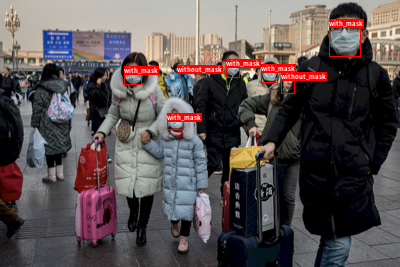

In [70]:
visualize_results(x, y_nms)

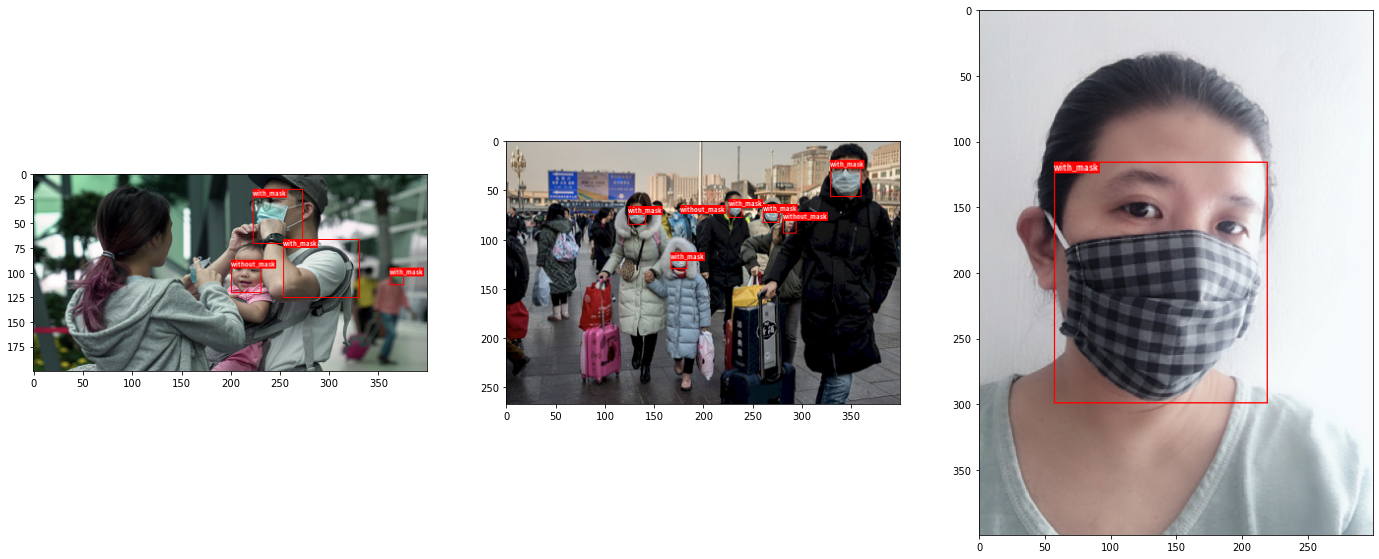

In [71]:
plt.figure(figsize = (24, 12))
net.eval()
for i in range(3):
    x, t = test2[i]
    y = net(x.unsqueeze(0))[0]
    keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
    y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
    image = visualize_results(x, y_nms)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

# Calculate Mean Average Precision (mAP)

In [72]:
%%capture
!if [ ! -d vision ]; then git clone https://github.com/pytorch/vision.git && cd vision && cp references/detection/utils.py ../ && cp references/detection/transforms.py ../ && cp references/detection/coco_eval.py ../ && cp references/detection/engine.py ../ && cp references/detection/coco_utils.py ../; fi

In [73]:
!ls

__notebook__.ipynb  coco_utils.py  fonts	   transforms.py  vision
coco_eval.py	    engine.py	   lightning_logs  utils.py


In [74]:
pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6f071bjl
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6f071bjl
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=371240 sha256=7378411dbc89606c6708206b002f0d0a6e79bb2d75ebb9f4f412d44594e34bf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ta_qi6m0/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Note: you may need to restart the kernel to use updated packages.


In [75]:
from engine import evaluate

In [76]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [77]:
pl.seed_everything(0)
net.to(device)
evaluate(net, test_loader, device)

creating index...
index created!
Test:  [0/7]  eta: 0:00:07  model_time: 1.0176 (1.0176)  evaluator_time: 0.0187 (0.0187)  time: 1.0397  data: 0.0003  max mem: 14043
Test:  [6/7]  eta: 0:00:00  model_time: 0.8268 (0.7901)  evaluator_time: 0.0187 (0.0185)  time: 0.8115  data: 0.0001  max mem: 14043
Test: Total time: 0:00:05 (0.8123 s / it)
Averaged stats: model_time: 0.8268 (0.7901)  evaluator_time: 0.0187 (0.0185)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.

# Save the Model

In [78]:
torch.save(net.model, 'object_detection_facemask_pred_model.pth')

In [79]:
saved_model = torch.load('/kaggle/working/object_detection_facemask_pred_model.pth')

In [80]:
saved_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(